In [84]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import scipy
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

from networkx.algorithms import bipartite

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [85]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [86]:
DATA_PATH = './preprocessed_data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_preprocessed.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_preprocessed.tsv')
SCORE_PATH = os.path.join(DATA_PATH, 'score_function.tsv')
CAREER_BOOSTER_PATH = os.path.join(DATA_PATH, './career_boosters')
CAREER_BOOSTER_IDs = os.path.join(DATA_PATH, 'career_boosters_ids.csv')
IMAGE_PATH = './images'

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [87]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars['min_year'].fillna(0, inplace=True)
df_chars['min_year_score'].fillna(0, inplace=True)
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,0.0,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,2000.0,57.0


### 1.2 The data score

In [88]:
df_numbers=pd.read_csv(SCORE_PATH, sep='\t')
df_numbers.drop(['min_year', 'min_year_score'], axis=1, inplace=True)
df_numbers.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Jane Fonda,99.0,346.5,181.5,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,...,38.038043,36.229737,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250
1,Clint Eastwood,348.0,174.0,460.0,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,...,1551.673707,3219.994472,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952


### 2.1 Dataset preparation

In [89]:
df_chars_merged = df_chars.merge(df_numbers, on='actor_name', how='left').copy()
numbers_columns = df_numbers.columns[1:]
df_chars_merged[numbers_columns] = df_chars_merged[numbers_columns].fillna(0)
df_chars_merged['min_year'] = df_chars_merged['min_year'].astype('int')
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,Ghosts of Mars,...,42.750000,34.200000,28.500000,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,Ghosts of Mars,...,1356.146032,2146.828571,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,645.500000,477.600000,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,764.333333,388.000000,261.583333,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333


In [90]:
nb_actors = df_chars_merged['actor_name'].nunique()
print("There are {} actors in this dataset.".format(nb_actors))

There are 34388 actors in this dataset.


In [91]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2005,2006,2007,2008,2009,2010,2011,2012,is_revealed,already_revealed
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,Ghosts of Mars,...,28.500000,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846,0,1
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,Ghosts of Mars,...,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,0,1
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,0,1
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,261.583333,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333,0,1


### 2.2 Movies that have a revelation

In [92]:
df_movie_revelation = df_chars_merged.groupby(['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA']).agg({'is_revealed': 'sum', 'already_revealed':'sum'}).copy().reset_index()
df_movie_revelation['m_release_year'] = df_movie_revelation['m_release_date'].dt.year
df_movie_revelation.rename({'is_revealed' : 'has_revelation', 'already_revealed' : 'has_famous_actors'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
0,3217,1992-10-09,"Gross-out film, Gross out, Comedy, Romance Film",1,0,1992
1,3333,1915-01-01,"Business, Computers, Finance & Investing, Anti...",0,0,1915
2,3746,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",1,1,1982
3,3837,1974-02-07,"Action/Adventure, Action, Comedy, Action Thril...",0,0,1974
4,3947,1986-08-01,"Detective, Crime Thriller, Detective fiction, ...",0,1,1986


In [93]:
nb_movies = df_movie_revelation['wikipedia_m_ID'].nunique()
nb_movies_revelation = df_movie_revelation['has_revelation'].value_counts()[1]
print("There are {} movies with a revelation which represents {:.2f}% of the movies.".format(nb_movies_revelation, nb_movies_revelation*100/nb_movies))
#df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_revelation'] > 0)]

There are 1859 movies with a revelation which represents 7.48% of the movies.


In [94]:
nb_movies_with_famous_actor = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors']>0) & (df_movie_revelation['has_revelation']>0)].shape[0]
print("Among movies with a revelation, there are {} movies with at least one famous actor which represents {:.2f}% of the movies with revelation.".format(nb_movies_with_famous_actor, nb_movies_with_famous_actor*100/nb_movies_revelation))

Among movies with a revelation, there are 1490 movies with at least one famous actor which represents 80.15% of the movies with revelation.


Text(0, 0.5, 'Movie genre retrieved using PCA')


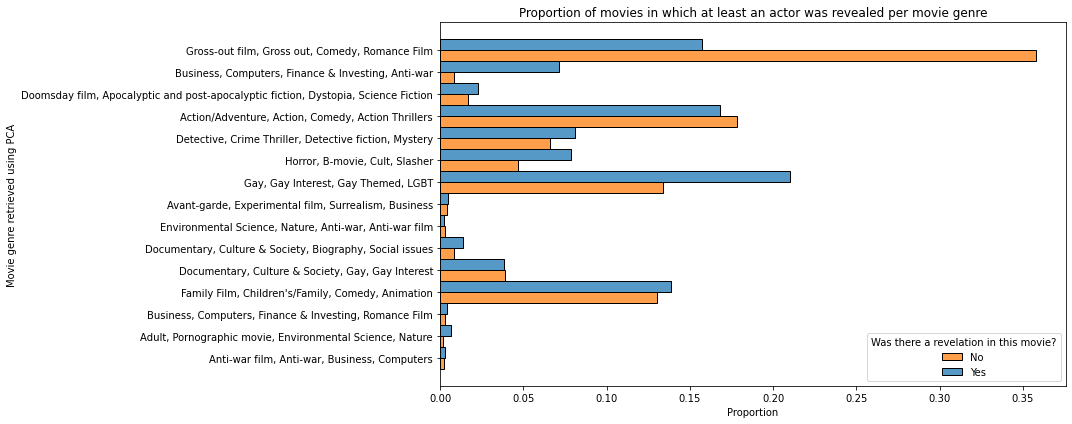

In [105]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
sns.histplot(data=df_movie_revelation, y='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.title("Proportion of movies in which at least an actor was revealed per movie genre")
plt.ylabel("Movie genre retrieved using PCA")
plt.xlabel("Proportion")
plt.legend(title='Was there a revelation in this movie?', loc='lower right', labels=['No', 'Yes'])
y_labels = ax.get_yticks()

y_labels = axs.yaxis.get_label()
print(y_labels)
#ax.set_yticklabels(['1e%i' % np.round(np.log(y)/np.log(10)) for y in y_labels])
#ax.set_yticklabels(['{:10}' for y in y_labels])

plt.tight_layout()
#plt.xticks(rotation=90)
plt.show()

In [13]:
#For the movie with no famous actor, the revelation must come from another factor than co-acting.
#Therefore, we decided to only focus on movies that had at least one actor, to analyse co-acting impact.
df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors'] > 0)]
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
2,3746,1982-06-25,"Thriller, Crime Thriller, Action, Mystery",1,1,1982
4,3947,1986-08-01,"Thriller, Crime Thriller, Action, Mystery",0,1,1986
6,4231,1992-07-31,"Horror, B-movie, Gay, Gay Interest",0,2,1992
7,4560,1995-05-18,"Biography, Culture & Society, Social issues, D...",0,1,1995
8,4726,1989-06-19,"Thriller, Crime Thriller, Action, Mystery",0,3,1989


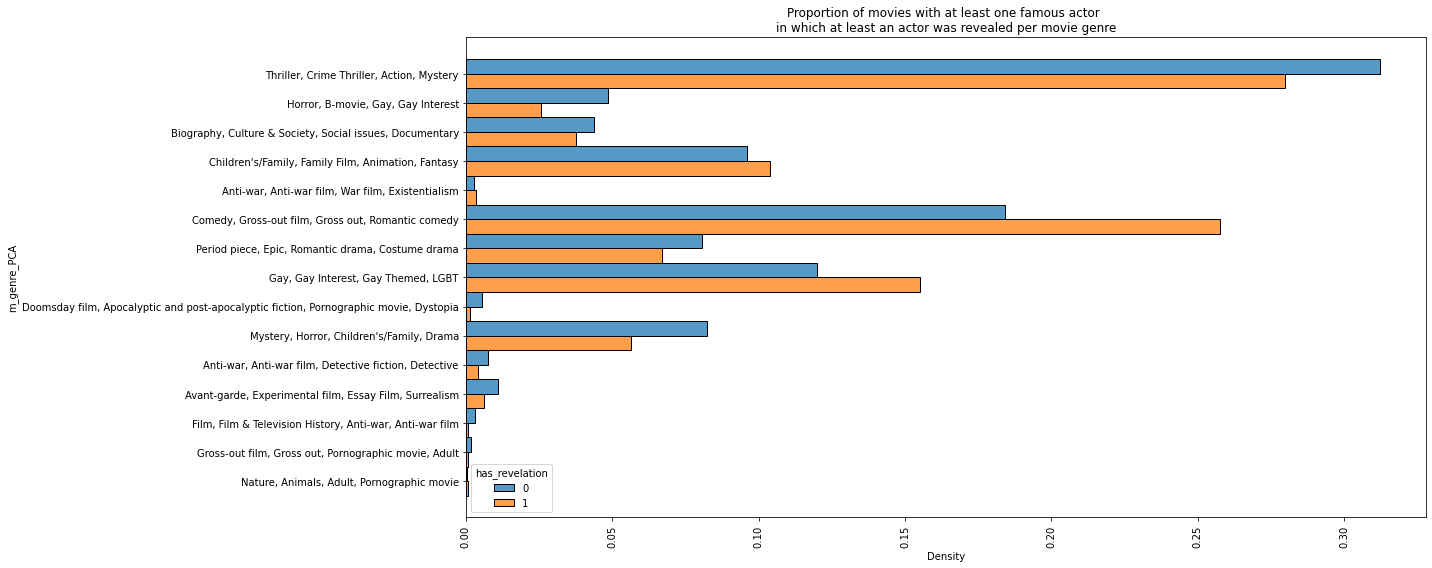

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
sns.histplot(data=df_movie_revelation, y='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.title("Proportion of movies with at least one famous actor \nin which at least an actor was revealed per movie genre")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
image_format = 'jpg'
OUTPUT_IMG_GENRE_HAS_REVELATION = 'movie_genre_has_a_revelation.jpg'
image_name = OUTPUT_IMG_GENRE_HAS_REVELATION

fig.savefig(image_name, format=image_format, dpi=1200, transparent=False)

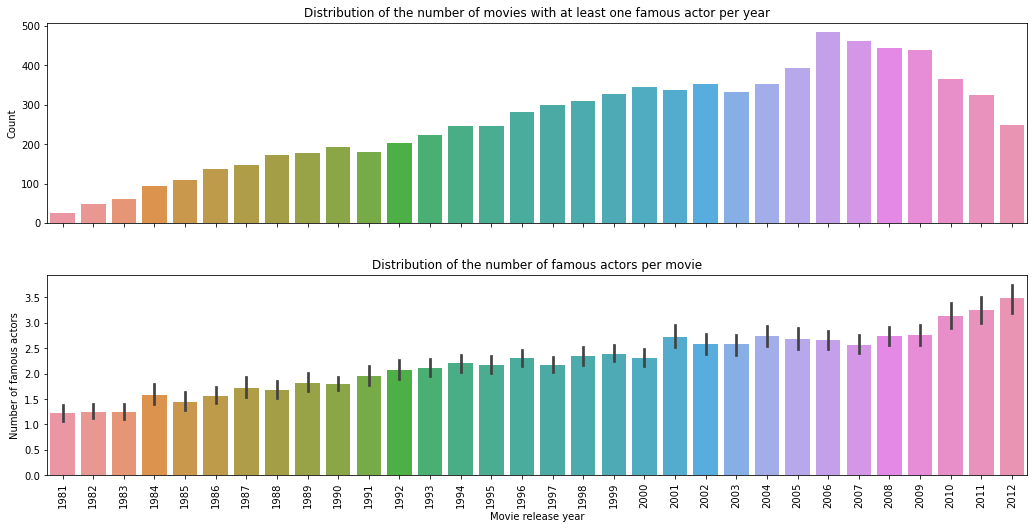

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
data_grouped = df_movie_revelation.groupby('m_release_year')['wikipedia_m_ID'].count().reset_index()
ax = axs[0]
sns.barplot(data=data_grouped,x='m_release_year', y='wikipedia_m_ID', ax=ax)
ax.set_title("Distribution of the number of movies with at least one famous actor per year")
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[1]
sns.barplot(data=df_movie_revelation,x='m_release_year', y='has_famous_actors', ax=ax)
ax.set_title("Distribution of the number of famous actors per movie")
plt.xticks(rotation = 90)
fig.tight_layout(pad=3.0)
ax.set_xlabel('Movie release year')
ax.set_ylabel('Number of famous actors')
plt.show()

As it can be seen, there is an increase in the number of movies per year but also a major increase in the number of famous actors per movie.
The second observation can be due to two facts:
* The global increase in the number of movies
* The scoring system: once you've been releaved, you stay famous. But the earlier we are, the less information we have about actors that were releaved before 1980 but for whom we don't have an accurate score.

For those two reasons, the time period will be split into 6 blocks, so that movies with comparable number of famous actors will be compared.

### 2.3 Revelation per pentade

In [40]:
nb_five_years_lower = range(1982, 2008,5)
nb_five_years_upper = range(1987, 2013, 5)

In [41]:
def define_popularity(min_year, lower_bound, upper_bound):
    if not min_year or min_year >= upper_bound:
        return 'unknown'
    if min_year < lower_bound:
        return 'famous'
    else:
        return 'revelation'

In [51]:
df_chars_revelation = df_movie_revelation.merge(df_chars_merged, on=['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA'], how='inner').copy()
df_revelations_five_years = dict()
for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
    filter_conditions = (
        (df_chars_revelation['m_release_date'].dt.year >= y_lower) & 
        (df_chars_revelation['m_release_date'].dt.year < y_upper)
    )
    columns = ['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA','actor_name', 'actor_dob', 'is_revealed', 'already_revealed', 'min_year']
    df_filtered = df_chars_revelation.loc[filter_conditions, columns].copy()
    df_filtered['popularity'] = df_filtered['min_year'].apply(lambda x: define_popularity(x, y_lower, y_upper))
    df_revelations_five_years.update({range(y_lower, y_upper): df_filtered.copy()})

In [52]:
def get_attributes(df_, graph_, previous_score):
    """
    Find attributes of the actors, attributes are ['actor_name', 'actor_dob', 'min_year', 'popularity']
    :param df_: original df with on which to merge.
    :param graph_: second dataframe that used to merge.
    :param previous_score: score the actor had the previous year
    :return: revelation: dictionnary of revelated actors
             famous: dictionnary of famous actors
             attrs_: attirbutes of revelations and famous
    """
    df_revelation = df_.merge(graph_.drop_duplicates('actor_name_x', keep='first'), left_on='actor_name', right_on='actor_name_x', how='inner')[['actor_name','actor_dob', 'min_year', 'popularity']]
    revelation = df_revelation.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    df_famous = df_.merge(graph_.drop_duplicates('actor_name_y', keep='first'), left_on='actor_name', right_on='actor_name_y', how='inner')[['actor_name','actor_dob', 'min_year', 'popularity' , '{}'.format(previous_score)]]
    famous = df_famous.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    attrs_ = dict()
    attrs_.update(revelation)
    attrs_.update(famous)
    
    return revelation, famous, attrs_

In [53]:
def create_bipartite_graph(revelation, famous, attrs_, graph_):
    """
    Creates a bipartite graph with left nodes: revelation actors and right nodes: famous actors
    :param revelation: dictionnary of revelated actors
    :param famous: dictionnary of famous actors
    :param attrs_: attirbutes of revelations and famous
    :param graph_: df with actors and films that will be grahed
    :return: bipartite_graph: bipartie graph
    """
    B = nx.Graph()
    B.add_nodes_from(revelation, bipartite=0)
    B.add_nodes_from(famous, bipartite=1)
    B.add_weighted_edges_from([(row['actor_name_x'], row['actor_name_y'], 1) for idx, row in graph_.iterrows()], weight='weight')

    colors = []
    for node in B:
        val = attrs_[node]['popularity']
        if val =='revelation':
            colors.append("green")
        elif val =='famous':
            colors.append("red")
        else:
            colors.append("gray")
    
    pos = {node:[0, i] for i,node in enumerate(revelation.keys())}
    pos.update({node:[1, i] for i,node in enumerate(famous.keys())})
    
    bipartite_graph = {'graph': B, 'pos': pos, 'node_color':colors}
    
    return bipartite_graph

In [65]:
def extract_partition_nodes(G: nx.Graph, attrs_, partition: str):
    nodeset = [x for x in G.nodes if attrs_[x]['popularity'] == partition]
    if partition != "revelation" and partition!="famous":
        raise Exception(f"No nodes exist in the partition {partition}!")
    return nodeset

In [66]:
def retrieve_career_boosters(graph_, previous_score, attrs_):
    """
    Find the actors that were famous in a film whith a revelation
    :param graph_: df with actors and films that will be grahed
    :param previous_score: score the actor had the previous year
    :param attrs_: attirbutes of revelations and famous
    :return: bipartite_graph: bipartie graph
    """
    revelations_ = extract_partition_nodes(graph_,attrs_, "revelation")
    famous_ = extract_partition_nodes(graph_, attrs_, "famous")
    
    sources = revelations_
    targets = revelations_
    measures = dict()
    measures=['betweenness_centrality_subset', 'degree_centrality']
    
    bc_subset = nx.betweenness_centrality_subset(graph_, sources=sources, targets=targets)
    cc_subset = nx.degree_centrality(graph_)
    
    sorted_bc = sorted(bc_subset.items(), key=lambda kv: kv[1], reverse=True)
    sorted_cc = sorted(cc_subset.items(), key=lambda kv: kv[1], reverse=True)
    career_boosters_bc = []
    career_boosters_cc = []
    for (x, m) in sorted_bc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            dob = attrs_[x]['actor_dob']
            bc_measure = m
            cc_measure = cc_subset[x]
            famous_actor = {'actor_name':x,'actor_dob':dob, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_bc.append(famous_actor)
    for (x, m) in sorted_cc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            dob = attrs_[x]['actor_dob']
            bc_measure = bc_subset[x]
            cc_measure = m
            famous_actor = {'actor_name':x,'actor_dob':dob, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_cc.append(famous_actor)
    
    return career_boosters_bc, career_boosters_cc

In [73]:
def compute_career_boosters_infos(df_, graph_, range_y, m_genre):
    career_booster_infos = dict()
    for i, x in enumerate(df_[:5], start=1):
        key = x['actor_name']
        score = x['score_in_{}'.format(range_y.start-1)]
        min_year = x['revealed_in']
        dob = x['actor_dob']
        ranking = i
        bc_measure = x['betweenness_centrality_subset']
        dc_measure = x['degree_centrality']
        casting = graph_[graph_['actor_name_y'] == key]
        nb_actors_boosted_at_revelation = casting[casting['is_revealed_x'] == 1].shape[0]
        nb_actors_boosted_before_revelation = casting[casting['is_revealed_x'] == 0].shape[0]
        nb_actors_boosted = casting.shape[0]
        tmp_booster = {'booster_in': range_y,
                       'm_genre': m_genre,
                       'dob': dob,
                       'ranking': i,
                       'betweenness_centrality_subset': round(bc_measure, 0),
                       'degree_centrality': round(dc_measure, 3),
                       'actor_score_before_period': round(score, 2),
                       'nb_actors_boosted': nb_actors_boosted,
                       'nb_actors_boosted_at_revelation': nb_actors_boosted_at_revelation,
                       'nb_actors_boosted_before_revelation': nb_actors_boosted_before_revelation
        }
        career_booster_infos.update({key: tmp_booster})
    career_boosters_info_df = pd.DataFrame.from_dict(career_booster_infos, orient='index')
    return career_boosters_info_df

In [76]:
def carreer_booster_retrieval_for_all_genres():

    graphs = dict()
    famous_ranking_bc = dict()
    famous_ranking_cc = dict()
    booster_bc = dict()
    booster_cc = dict()

    for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
        tmp_range = range(y_lower, y_upper)
        df_tmp = df_revelations_five_years[tmp_range].copy()
        df_tmp = df_tmp.merge(df_numbers[['actor_name', '{}'.format(y_lower-1)]], on='actor_name', how='left')
        df_tmp['{}'.format(y_lower-1)] = df_tmp['{}'.format(y_lower-1)].fillna(0)

        graph = pd.merge(df_tmp, df_tmp, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
        filter_conditions = (
            (graph.popularity_x == 'revelation') & 
            (graph.popularity_y == 'famous') &
            (graph.m_release_date.dt.year <= graph.min_year_x)
        )
        graph = graph.loc[filter_conditions]
        
        unique_genres = df_tmp['m_genre_PCA'].unique()
        genre_iteration = ['all'] + list(unique_genres)
        
        graphs_genre = dict()
        famous_ranking_bc_genre = dict()
        famous_ranking_cc_genre = dict()
        booster_bc_genre = dict()
        booster_cc_genre = dict()
        
        for genre in genre_iteration:
            graph_genre = graph.copy()
            df_genre = df_tmp.copy()
            #print(genre)
            if genre !='all':
                #print("there")
                filter_conditions = (
                    (graph_genre.m_genre_PCA == genre)
                )
                graph_genre = graph.loc[filter_conditions]
                filter_conditions = (
                    (df_genre.m_genre_PCA == genre)
                )
                df_genre = df_genre.loc[filter_conditions]
            revelation_attributes, famous_attributes, attrs = get_attributes(df_genre, graph_genre, y_lower-1)

            tmp_graph = create_bipartite_graph(revelation_attributes, famous_attributes, attrs, graph_genre)
            graphs_genre.update({genre: tmp_graph})

            tmp_famous_ranking_bc, tmp_famous_ranking_cc = retrieve_career_boosters(tmp_graph['graph'], y_lower-1, attrs)
            famous_ranking_bc_genre.update({genre: tmp_famous_ranking_bc})
            famous_ranking_cc_genre.update({genre: tmp_famous_ranking_cc})
            
            tmp_career_booster_bc = compute_career_boosters_infos(tmp_famous_ranking_bc[:5], graph_genre, tmp_range, genre)
            booster_bc_genre.update({genre: tmp_career_booster_bc})

            tmp_career_booster_cc = compute_career_boosters_infos(tmp_famous_ranking_cc[:5], graph_genre, tmp_range, genre)
            booster_cc_genre.update({genre: tmp_career_booster_cc})
            
        graphs.update({tmp_range: graphs_genre})
        famous_ranking_bc.update({tmp_range: famous_ranking_bc_genre})
        famous_ranking_cc.update({tmp_range: famous_ranking_cc_genre})
        booster_bc.update({tmp_range: booster_bc_genre})
        booster_cc.update({tmp_range: booster_cc_genre})
        
    return booster_bc, booster_cc, graphs


In [77]:
career_booster_bc = dict()
career_booster_dc = dict()

career_booster_bc, career_booster_dc, graph = carreer_booster_retrieval_for_all_genres()

### 2.3 Create the plots for every pentade and PCA genre

In [78]:
with open(CAREER_BOOSTER_IDs, 'w') as f:
    writer = csv.writer(f)
    for key_year, val_year in career_booster_dc.items():
        for key_genre, val_genre in val_year.items():
            name_genre = key_genre.replace(' ', '_')
            name_genre = ''.join(item for item in name_genre if (item.isalnum() or item=='_'))
            row = [key_year.start, key_year.stop-1, name_genre]
            writer.writerow(row)

In [79]:
for key_year, val_year in career_booster_dc.items():
    for key_genre, val_genre in val_year.items():
        name_genre = key_genre.replace(' ', '_')
        name_genre = ''.join(item for item in name_genre if (item.isalnum() or item=='_'))
        name_pkl = "career_booster_dc_{}_{}_genre_{}.pkl".format(key_year.start, key_year.stop-1, name_genre)
        
        OUTPUT_PKL = os.path.join(CAREER_BOOSTER_PATH, name_pkl)
        val_genre.to_pickle(OUTPUT_PKL)

# 3. Plot the bipartite graphs

In [80]:
genre = "Thriller, Crime Thriller, Action, Mystery"

In [81]:
#plot the labels in the images
def show_labels_plt():
    plt.scatter([],[], c=['red'], label='Famous actors')
    plt.scatter([],[], c=['green'], label='Revelations')

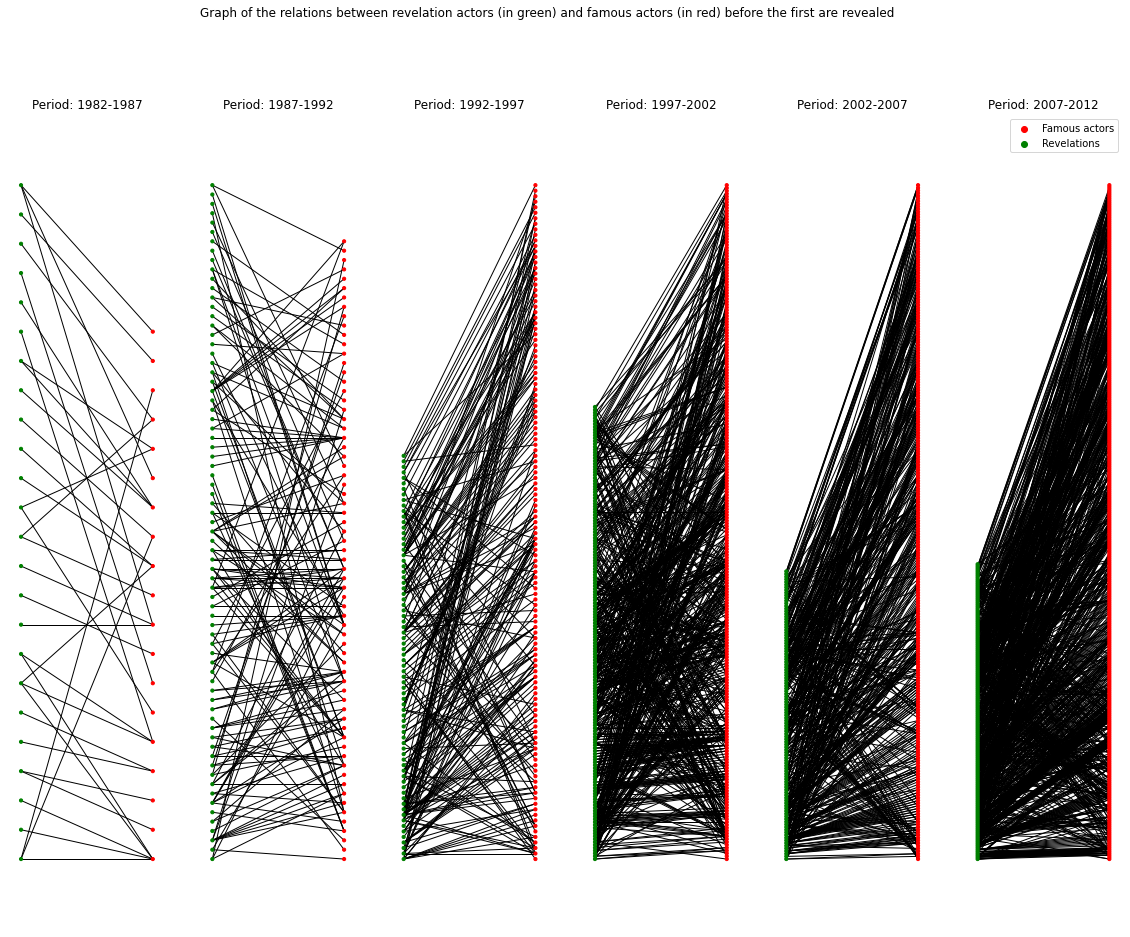

In [82]:
fig, axs = plt.subplots(1, 6, figsize=(20, 15))
for i, year in enumerate(graph):
    G = graph[year][genre]['graph']
    pos = graph[year][genre]['pos']
    node_color = graph[year][genre]['node_color']
    nx.draw(G, pos=pos, node_color=node_color, with_labels=False, node_size=10, ax=axs[i])
    axs[i].set_title("Period: {}-{}".format(year.start, year.stop))
    
fig.suptitle('Graph of the relations between revelation actors (in green) and famous actors (in red) before the first are revealed')

show_labels_plt()

plt.legend()
plt.show()

fig.tight_layout()

In [83]:
for k_year, v_year in career_booster_dc.items():
    print("\nRESULTS FOR PERIOD on ALL GENRES: {}-{}".format(k_year.start, k_year.stop))
    print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format('rank', 'name', 'score', 'nb_actors_boosted', 'nb_actors_boosted_at_revelation', 'nb_actors_boosted_before_revelation'))
    #print(v_year['all'].items())
    for i, row in v_year['all'].reset_index().iterrows():
        ranking = row['ranking']
        k_actor = row['index']
        actor_score_before_period = row['actor_score_before_period']
        nb_actors_boosted = row['nb_actors_boosted']
        nb_actors_boosted_at_revelation = row['nb_actors_boosted_at_revelation']
        nb_actors_boosted_before_revelation = row['nb_actors_boosted_before_revelation']
        print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format(ranking, k_actor, round(actor_score_before_period), nb_actors_boosted, nb_actors_boosted_at_revelation, nb_actors_boosted_before_revelation))


RESULTS FOR PERIOD on ALL GENRES: 1982-1987
rank : name               score  nb_actors_boosted nb_actors_boosted_at_revelation  nb_actors_boosted_before_revelation
1    : Dennis Quaid       250    13                12                               1    
2    : Chevy Chase        885    13                8                                5    
3    : Dan Aykroyd        198    9                 4                                5    
4    : William Hurt       240    9                 7                                2    
5    : Kurt Russell       142    8                 4                                4    

RESULTS FOR PERIOD on ALL GENRES: 1987-1992
rank : name               score  nb_actors_boosted nb_actors_boosted_at_revelation  nb_actors_boosted_before_revelation
1    : John Candy         698    14                12                               2    
2    : Rick Moranis       152    13                10                               3    
3    : Charlie Sheen      490    9      